In [1]:
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from HiSiNet.HiCDatasetClass import HiCDataset, SiameseHiCDataset
from HiSiNet.reference_dictionaries import reference_genomes
from HiSiNet import models
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import sys
 
import torch.nn.functional as F
def test_model(model, dataloader):
    distances = np.array([])
    labels = np.array([])
    for _, data in enumerate(dataloader):
        input1, input2, label = data
        label = label.type(torch.FloatTensor)#.to(cuda)
        output1, output2 = model(input1, input2)
        predicted = F.pairwise_distance(output1,output2)
        distances = np.concatenate((distances, predicted.cpu().detach().numpy()))
        label = label.type(torch.FloatTensor)
        labels  = np.concatenate((labels, label.cpu().detach().numpy()))
    return distances, labels


In [2]:
path="PATH_TO_TWINS_DATA_FILE"

In [3]:
model = eval("models.SLeNet")(mask=True)
model.load_state_dict(torch.load(path+"/models/main_datasets/NPC_CTCFdegron_10kb.ckpt", map_location=torch.device('cpu')))
model.eval()
 
 
list_of_HiCDatasets =[HiCDataset.load(data_path) for data_path in [path +"/data/NPC_data/d4_test_auxrep1_10kb.mlhic",
                                                        path +"/data/NPC_data/d4_test_auxrep2_10kb.mlhic",
                                                        path +"/data/NPC_data/d4_test_ctlrep1_10kb.mlhic", 
                                                        path +"/data/NPC_data/d4_test_ctlrep2_10kb.mlhic"]]

Siamese =  SiameseHiCDataset(list_of_HiCDatasets,reference = reference_genomes["mm10"])
 
 
test_sampler_siam = SequentialSampler(Siamese)
dataloader_siam = DataLoader(Siamese, batch_size=100, sampler = test_sampler_siam)
distances, labels_siam = test_model(model, dataloader_siam)
pd_dict = Siamese.get_genomic_positions(append="chr")
pd_dict["distances"] = distances
df = pd.DataFrame(pd_dict)
df["labels"]=Siamese.labels
df["labels_siam"]=labels_siam

<AxesSubplot:xlabel='Start', ylabel='distances'>

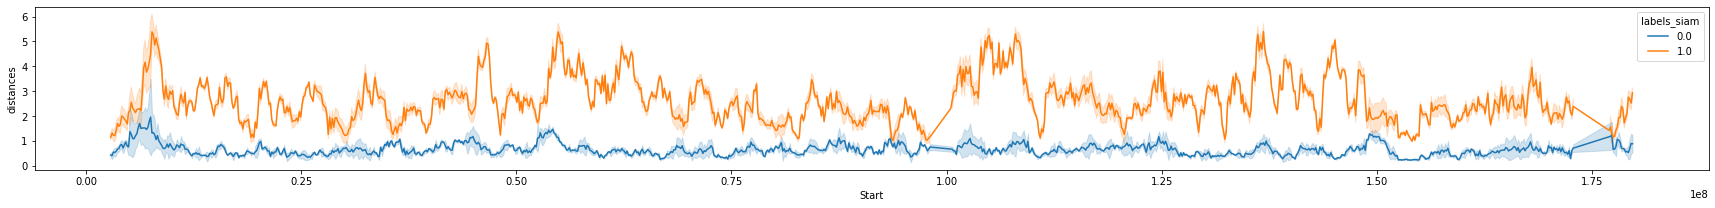

In [4]:
%config InlineBackend.figure_formats = ['png']

fig, (ax1) = plt.subplots(1,1, figsize=(30,3) )   
sns.lineplot(x=df.Start, y=df.distances, hue=df.labels_siam, ax=ax1)